In [4]:
from os import listdir
from os.path import isfile, join
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap



import re
from IPython import display
import glob
import imageio
from datetime import datetime
from tqdm import tqdm
import re
import netCDF4

from pyproj import Proj, transform
from mpl_toolkits.basemap import Basemap

First define some helpfull functions. One that extract a datetime from the filename and an other function that loads a radar file from the right directory

In [10]:
reg_dt = '_([^_]+)\.'
def get_datetime(filename):
    '''
    Infer datetime from filename
    '''
    try:
        timestamp= re.findall(reg_dt,filename)[0]
        dt = datetime.strptime(timestamp, '%Y%m%d%H%M')
    except:
        print('Error: could not find timestamp in file {}'.format(filename))
    return dt

dir_rtcor = '/nobackup_1/users/schreurs/project_GAN/dataset_radar/'
rtcor_fbase = 'RAD_NL25_RAC_RT_'
dir_aart = '/nobackup_1/users/schreurs/project_GAN/dataset_aart/'
aart_fbase = 'RAD_NL25_RAC_MFBS_EM_5min_'

def load_radar(filename, as_int=False):
    '''
    Loads the radar file belonging to the filename. 
    Looks at the file extension to see from which dataset to retrieve from.
    filename: String filename, can also be just a timestamp (YYYYMMDDhhmm) followed by extension .h5 or .nc
    as_int: if true, the (discreet!) decimal values are converted to integers. 
    '''
    path = dir_rtcor + rtcor_fbase + filename
    if filename.endswith('.h5'):
        if rtcor_fbase in filename:
            path = dir_rtcor + filename
        # Open rtcor
        try:
            with h5py.File(path, 'r') as f:
                rain = f['image1']['image_data'][:]
                mask= (rdr == 65535)
                mx = np.ma.masked_array(rain, mask)
                return mx
        except:
            rdr_empty = np.zeros((765, 700, 1))
            return rdr_empty
            
    if filename.endswith('.nc'):
        path = dir_aart + aart_fbase + filename
        if aart_fbase in filename:
            path = dir_aart + filename
        with netCDF4.Dataset(path, 'r') as f:
            rain = f['image1_image_data'][:]
            
            if as_int:
                rain *=100
                rain = rain.astype(int)
            # Change to image format (w,h,c) instead of (c,w,h)
            rain = np.moveaxis(rain, 0, -1)
            return rain

In [9]:
def plot_radar(rdr):
    plt.imshow(np.squeeze(rdr))
    plt.axis('off')
    plt.show()

# Data: rtcor files

In [226]:
radar_dir = '/nobackup_1/users/schreurs/project_GAN/dataset_radar'
files = sorted([f for f in listdir(radar_dir) if isfile(join(radar_dir, f))])
print(len(files))

228474


RAD_NL25_RAC_RT_201812201245.h5


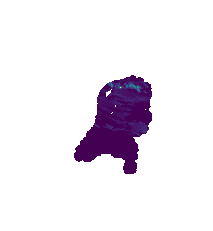

In [227]:
print(files[1050])
rdr = load_radar(files[1050])
plot_radar(rdr)

# Precipitation in 2020

There are a lot of files in the dataset. It would take a lot of computations to measure mean precipitation and other information of the complete dataset. Therefor I will first only look at the year 2020.

In [168]:
base = 'RAD_NL25_RAC_RT_' 
# Get start and end index
# 2020 01 01 00:00
start = base + '202001010000.h5'
# 2020 12 31 11:55
end = base + '202012311155.h5'
start_i = files.index(start)
end_i = files.index(end)
print(start_i, end_i)
files_2020 = files[start_i:end_i]
print('Nr. of days in dataset: ', len(files_2020)/288)

108161 213256
Nr. of days in dataset:  364.91319444444446


Note that 2020 was a leap year, so there should be 366 days in the dataset. As you can see a little more than a day is missing from the data

In [169]:
sum_rain2020 = []
empty_files=[]
for file in tqdm(files_2020):
    date = get_datetime(file)
    rdr = load_radar(file)
    sum_rain2020.append([date, rdr.sum()])

100%|██████████| 105095/105095 [04:19<00:00, 405.06it/s]


In [122]:
np_arr = np.array(sum_rain2020)

In [123]:
np.save('/nobackup_1/users/schreurs/project_GAN/sum_rain2020', np_arr)

In [125]:
df = pd.DataFrame({'date': np_arr[:, 0], 'mean_rain': np_arr[:, 1]})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,mean_rain
date,
2020-01-01 00:00:00,6859483114
2020-01-01 00:05:00,6859483031
2020-01-01 00:10:00,6859483052
2020-01-01 00:15:00,6859483089
2020-01-01 00:20:00,6859483201


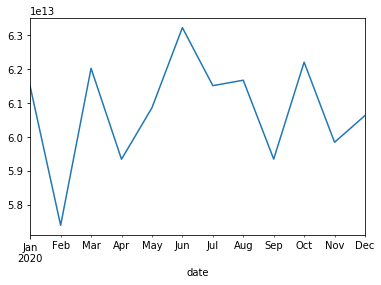

In [126]:
monthly_rain = df.mean_rain.resample('M').sum()
monthly_rain.plot()

In [9]:
sumrain19 = np.load('/nobackup_1/users/schreurs/project_GAN/sum_rain2020.npy', allow_pickle=True)
df = pd.DataFrame({'date': sumrain19[:, 0], 'mean_rain': sumrain19[:, 1]})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,mean_rain
date,
2020-01-01 00:00:00,6859483114
2020-01-01 00:05:00,6859483031
2020-01-01 00:10:00,6859483052
2020-01-01 00:15:00,6859483089
2020-01-01 00:20:00,6859483201


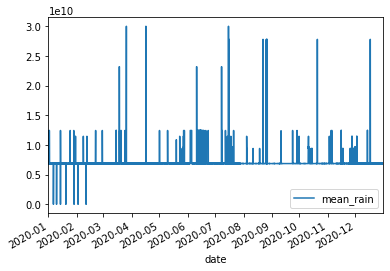

## Precipitation from 2018 till now

In [7]:
mean_rain = []
for file in tqdm(files):
    date = get_datetime(file)
    rdr = load_radar(file)
    if rdr.data.size is not 1:
        mean_rain.append([date, rdr.mean()])
np_arr = np.array(mean_rain)
np.save('/nobackup_1/users/schreurs/project_GAN/mean_rain', np_arr)

100%|██████████| 227679/227679 [51:07<00:00, 74.23it/s]  


In [8]:

radar_dir = '/nobackup_1/users/schreurs/project_GAN/dataset_radar_np/'
label_dir = '/nobackup_1/users/schreurs/project_GAN/rtcor_rain_labels/'

files = sorted([f for f in listdir(radar_dir) if isfile(join(radar_dir, f)) and f.startswith('2019')])

sum_rain = []
for file in tqdm(files):
    try:
        rdr = np.load(radar_dir+file)
        date = datetime.strptime(file.replace('.npy', ''), '%Y%m%d%H%M')
        sum_rain.append([date, np.sum(rdr)])
    except Exception as e:
        print(e)
np_arr = np.array(mean_rain)
#np.save('/nobackup_1/users/schreurs/project_GAN/mean_rain', np_arr)

 25%|██▍       | 25903/103853 [00:17<00:49, 1569.61it/s]

Object arrays cannot be loaded when allow_pickle=False


 26%|██▌       | 26685/103853 [00:23<12:31, 102.66it/s] 

Object arrays cannot be loaded when allow_pickle=False


 27%|██▋       | 27675/103853 [00:33<13:12, 96.10it/s] 

Object arrays cannot be loaded when allow_pickle=False


 28%|██▊       | 29521/103853 [00:51<12:17, 100.75it/s]

Object arrays cannot be loaded when allow_pickle=False


 35%|███▌      | 36610/103853 [02:01<11:06, 100.87it/s]

Object arrays cannot be loaded when allow_pickle=False


 56%|█████▋    | 58483/103853 [05:35<07:10, 105.38it/s]

Object arrays cannot be loaded when allow_pickle=False


 57%|█████▋    | 58979/103853 [05:40<07:13, 103.41it/s]

Object arrays cannot be loaded when allow_pickle=False


 57%|█████▋    | 59357/103853 [05:43<07:37, 97.27it/s] 

Object arrays cannot be loaded when allow_pickle=False


 60%|██████    | 62586/103853 [06:14<06:29, 106.08it/s]

Object arrays cannot be loaded when allow_pickle=False


 62%|██████▏   | 64685/103853 [06:34<06:29, 100.66it/s]

Object arrays cannot be loaded when allow_pickle=False


 63%|██████▎   | 65382/103853 [06:41<06:19, 101.39it/s]

Object arrays cannot be loaded when allow_pickle=False


 69%|██████▉   | 71623/103853 [07:41<05:09, 104.14it/s]

Object arrays cannot be loaded when allow_pickle=False


 78%|███████▊  | 81150/103853 [09:12<03:32, 106.86it/s]

Object arrays cannot be loaded when allow_pickle=False


 82%|████████▏ | 84647/103853 [09:46<02:57, 107.99it/s]

Object arrays cannot be loaded when allow_pickle=False


 91%|█████████▏| 94977/103853 [11:24<01:32, 95.68it/s] 

Object arrays cannot be loaded when allow_pickle=False


 92%|█████████▏| 95747/103853 [11:32<01:20, 101.13it/s]

Object arrays cannot be loaded when allow_pickle=False


 94%|█████████▎| 97136/103853 [11:45<01:07, 98.80it/s] 

Object arrays cannot be loaded when allow_pickle=False


 95%|█████████▍| 98509/103853 [11:58<00:51, 104.26it/s]

Object arrays cannot be loaded when allow_pickle=False


 98%|█████████▊| 101399/103853 [12:26<00:23, 103.24it/s]

Object arrays cannot be loaded when allow_pickle=False


100%|██████████| 103853/103853 [12:49<00:00, 134.93it/s]


NameError: name 'mean_rain' is not defined

In [9]:
np_arr = np.array(sum_rain)
#np.save('/nobackup_1/users/schreurs/project_GAN/mean_rain', np_arr)

In [10]:
df = pd.DataFrame({'date': np_arr[:, 0], 'sum_rain': np_arr[:, 1]})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df['month'] = df.index.month
df.head()

,sum_rain
date,
2019-01-01 00:00:00,14
2019-01-01 00:05:00,10
2019-01-01 00:10:00,4
2019-01-01 00:15:00,18
2019-01-01 00:20:00,23


(0.0, 200000.0)

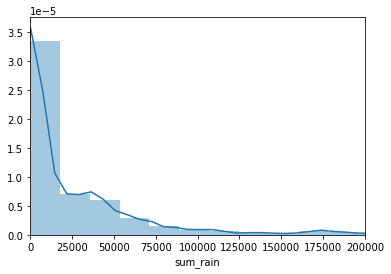

In [37]:
import seaborn as sns
sns.distplot(df[df.index.month == 1]['sum_rain'])
plt.xlim(0,20*10000)

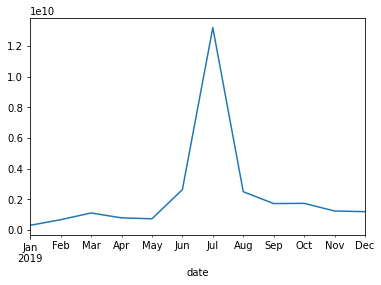

In [11]:
monthly_rain = df.sum_rain.resample('M').sum()
monthly_rain.plot()

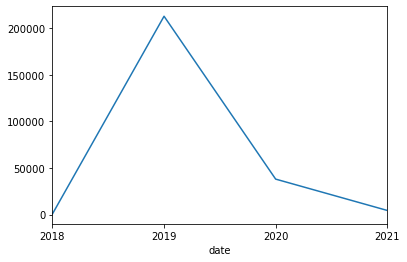

In [12]:
df.mean_rain.resample('Y').sum().plot()

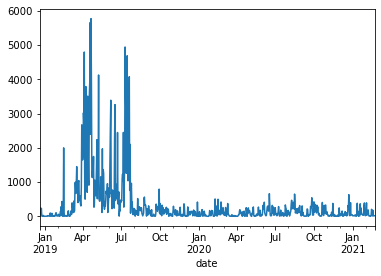

In [13]:
df.mean_rain.resample('d').sum().plot()

## Max of the data

The input data should be normalized. For now we simply choose minmax normalization. In order to do this we need to compute the maximum value. The minimum rain value is already known (0mm/h)

In [4]:
radar_dir = '/nobackup_1/users/schreurs/project_GAN/dataset_radar_np/'
files = sorted([f for f in listdir(radar_dir) if isfile(join(radar_dir, f)) and f.startswith('2019')])
print(len(files))

103853


In [5]:
print(files[0], files[-1])

201901010000.npy 201912312355.npy


In [34]:
files_max=[]
max_vs=[]
max_v = 0 
# max 5461 from file 0 to 26015, it crashed after that
for f in tqdm(files):
    try:
        rdr = np.load(radar_dir+f)
        rdr[rdr == 65535] = 0
        if rdr.max() > max_v:
            max_vs.append(rdr.max())
            files_max.append(f)
            max_v = rdr.max()
    except:
        continue

100%|██████████| 103853/103853 [22:42<00:00, 76.20it/s]


In [140]:
max_v

52254

In [15]:
files[5]

'201901010025.npy'

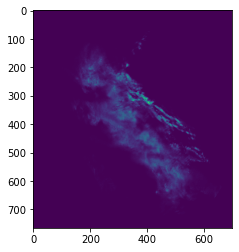

In [33]:
f = '201906060025.npy'
rdr = np.load(radar_dir+f)
#rdr[rdr == 65535] = 0
rdr[rdr > 500] = 0

plt.imshow(rdr)

In [34]:
f = '201906060000.npy'
rdr = np.load(radar_dir+f)
rdr[rdr == 65535] = 0
print('RTCOR')
print(np.unique(rdr))

y_path = '/nobackup_1/users/schreurs/project_GAN/dataset_aart_np/'
rdr2 = np.load(y_path+f)
rdr2[rdr2 == 6553500] = 0
print('Aart')
print(np.unique(rdr2))



RTCOR
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 

201907201940.npy
[501 558 575 589 648]
0.29824
No pixel above 0.3mm: False
Number of rainy pixels: 1081
0


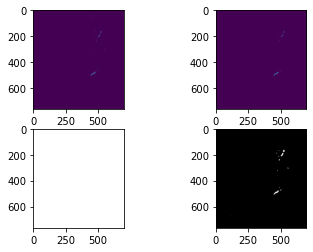

In [151]:
thresh_up=100*100
thresh_low=100*0.3

f = np.random.choice(files)
#f ='201906060000.npy'
rdr = np.load(radar_dir+f)
rdr[rdr == 255] = 0
rdr[rdr == 65535] = 0
print(f)
print(np.unique(rdr)[-5:])
print('{:.5f}'.format(rdr.mean()))

rdr2 = np.load(radar_dir+f)

print('No pixel above 0.3mm:', rdr.max()<thresh_low)
print('Number of rainy pixels:', sum(sum(rdr>thresh_low)))
rdr2[rdr2 == 65535] = 0
rdr2[np.logical_or(rdr2 > thresh_up, rdr2 < thresh_low )] = 0


rdr3 = np.load(radar_dir+f)
print(np.sum(rdr3==65535))
rdr3[rdr3 == 65535] = 0
rdr3 = rdr3 > thresh_up

rdr4 = np.load(radar_dir+f)
rdr4[rdr4 == 65535] = 0
rdr4 = rdr4 < thresh_low 

plt.figure()
plt.subplot(2,2,1)
plt.imshow(rdr)
plt.subplot(2,2,2)
plt.imshow(rdr2)
plt.subplot(2,2,3)

plt.imshow(rdr3, cmap='binary')
plt.subplot(2,2,4)
plt.imshow(rdr4, cmap='binary')
plt.show()

In [142]:
count, value = np.histogram(rdr)
for i in range(len(count)):
    print(int(value[i]), '\t', count[i] )

0 	 535477
1 	 0
2 	 0
3 	 5
4 	 2
5 	 8
6 	 3
7 	 3
8 	 1
9 	 1


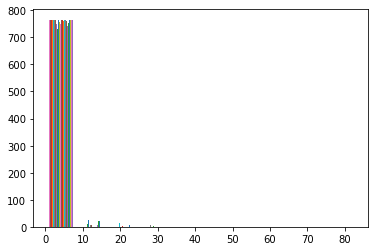

In [140]:
plt.hist(rdr, bins=10)
plt.show()

In [94]:
indices = np.where(rdr == rdr.max())
print('index max value:', indices)
for ind in indices:
    x_and_y =np.unravel_index(ind, rdr.shape) 
    print('x and y:', x_and_y)

index max value: (array([325]), array([351]))
x and y: (array([0]), array([325]))
x and y: (array([0]), array([351]))


In [72]:
rdr[0][0]

0

# Data: aart

In [4]:
radar_dir = '/nobackup_1/users/schreurs/project_GAN/dataset_aart'
files = sorted([f for f in listdir(radar_dir) if isfile(join(radar_dir, f)) and f.endswith('.nc')])
print(len(files))

1262113


# Precipitation in 2019

First only look at the year 2019. I ran into a problem were the total precipitation per month would be zero for a subset of the months. The reason for this is that some of the radar scans were completely masked. Aggregating the sum returns 0 if one if the item is masked. Solved this by checking if the radar sum can be represented as int, else define total precipitation as 0. In order to evaluate this I need to find out if a completely masked radar scan means there was indeed no rain at all at that time. 

Furthermore the rain values are stored as decimals. The values are however discreet with steps of 0.01. Therefor I converted the values to integers to prevent floating point errors.

In [38]:
# Get start and end index
# 2019 01 01 00:00
base = 'RAD_NL25_RAC_MFBS_EM_5min_'
start = base +'201901010000.nc'
# 2019 12 31 11:55
end = base+'201912311155.nc'
start_i = files.index(start)
end_i = files.index(end)
print(start_i, end_i)
files_2019 = files[start_i:end_i]
print('Nr. of days in dataset: ', len(files_2019)/288)
print(len(files_2019))

1051776 1156751
Nr. of days in dataset:  364.49652777777777
104975


In [90]:
sum_rain2019 = []
for file in tqdm(files_2019):
    date = get_datetime(file)
    rdr = load_radar(file, as_int=True)
    try:
        sum_rain2019.append([date, int(rdr.sum())])
    except:
        print(date)
        sum_rain2019.append([date, 0])

 29%|██▊       | 30172/104975 [03:52<09:52, 126.25it/s]

2019-04-15 16:35:00


 32%|███▏      | 33114/104975 [04:14<09:34, 125.15it/s]

2019-04-25 21:35:00


 33%|███▎      | 34404/104975 [04:25<09:17, 126.64it/s]

2019-04-30 09:05:00
2019-04-30 09:10:00
2019-04-30 09:15:00
2019-04-30 09:20:00
2019-04-30 09:25:00
2019-04-30 09:30:00
2019-04-30 09:35:00
2019-04-30 09:40:00
2019-04-30 09:45:00
2019-04-30 09:50:00
2019-04-30 09:55:00
2019-04-30 10:00:00
2019-04-30 10:05:00


 35%|███▍      | 36353/104975 [04:40<08:47, 130.14it/s]

2019-05-07 03:20:00


 40%|████      | 42368/104975 [05:26<08:07, 128.35it/s]

2019-05-28 00:35:00
2019-05-28 01:35:00
2019-05-28 01:40:00


 57%|█████▋    | 59836/104975 [07:43<05:50, 128.81it/s]

2019-07-27 17:05:00
2019-07-27 17:10:00
2019-07-27 17:15:00
2019-07-27 17:20:00
2019-07-27 17:25:00
2019-07-27 17:30:00
2019-07-27 17:35:00
2019-07-27 17:40:00
2019-07-27 17:45:00
2019-07-27 17:50:00
2019-07-27 17:55:00
2019-07-27 18:00:00


 68%|██████▊   | 71835/104975 [09:16<04:18, 128.31it/s]

2019-09-07 08:10:00


 79%|███████▊  | 82481/104975 [10:38<02:49, 132.93it/s]

2019-10-14 07:05:00


 89%|████████▉ | 93258/104975 [12:02<01:31, 127.82it/s]

2019-11-20 18:05:00
2019-11-20 18:10:00
2019-11-20 18:15:00
2019-11-20 18:20:00
2019-11-20 18:25:00
2019-11-20 18:30:00
2019-11-20 18:35:00
2019-11-20 18:40:00
2019-11-20 18:45:00
2019-11-20 18:50:00
2019-11-20 18:55:00
2019-11-20 19:00:00
2019-11-20 19:05:00
2019-11-20 19:10:00
2019-11-20 19:15:00
2019-11-20 19:20:00
2019-11-20 19:25:00
2019-11-20 19:30:00
2019-11-20 19:35:00
2019-11-20 19:40:00
2019-11-20 19:45:00
2019-11-20 19:50:00
2019-11-20 19:55:00
2019-11-20 20:00:00
2019-11-20 20:05:00
2019-11-20 20:10:00


 89%|████████▉ | 93284/104975 [12:02<01:31, 127.74it/s]

2019-11-20 20:15:00
2019-11-20 20:20:00
2019-11-20 20:25:00
2019-11-20 20:30:00
2019-11-20 20:35:00
2019-11-20 20:40:00
2019-11-20 20:45:00
2019-11-20 20:50:00
2019-11-20 20:55:00
2019-11-20 21:00:00
2019-11-20 21:05:00
2019-11-20 21:10:00
2019-11-20 21:15:00
2019-11-20 21:20:00
2019-11-20 21:25:00
2019-11-20 21:30:00
2019-11-20 21:35:00
2019-11-20 21:40:00
2019-11-20 21:45:00
2019-11-20 21:50:00
2019-11-20 21:55:00
2019-11-20 22:00:00


 89%|████████▉ | 93734/104975 [12:05<01:26, 129.29it/s]

2019-11-22 09:20:00


 90%|████████▉ | 94064/104975 [12:08<01:24, 129.75it/s]

2019-11-23 12:40:00


 99%|█████████▉| 103865/104975 [13:25<00:08, 127.01it/s]

2019-12-27 13:55:00
2019-12-27 14:00:00
2019-12-27 14:05:00
2019-12-27 14:10:00
2019-12-27 14:15:00
2019-12-27 14:20:00
2019-12-27 14:25:00
2019-12-27 14:30:00
2019-12-27 14:35:00
2019-12-27 14:40:00
2019-12-27 14:45:00
2019-12-27 14:50:00
2019-12-27 14:55:00
2019-12-27 15:00:00
2019-12-27 15:05:00
2019-12-27 15:10:00


100%|██████████| 104975/104975 [13:33<00:00, 128.99it/s]


In [91]:
np_arr = np.array(sum_rain2019)
np.save('/nobackup_1/users/schreurs/project_GAN/sum_rain_aart2019', np_arr)

In [92]:
np_arr = np.array(sum_rain2019)
df = pd.DataFrame({'date': np_arr[:, 0], 'mean_rain': np_arr[:, 1]})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,mean_rain
date,
2019-01-01 00:00:00,4
2019-01-01 00:05:00,0
2019-01-01 00:10:00,0
2019-01-01 00:15:00,6
2019-01-01 00:20:00,18


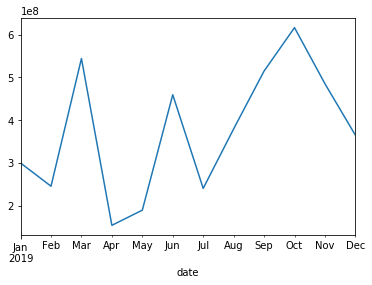

In [95]:
monthly_rain = df.mean_rain.resample('M').sum()
monthly_rain.plot()

Load the data and look at the distribution of total rain across all timestamps in 2019

In [40]:
np_arr =np.load('/nobackup_1/users/schreurs/project_GAN/sum_rain_aart2019.npy', allow_pickle=True)
df = pd.DataFrame({'date': np_arr[:, 0], 'total rain': np_arr[:, 1]})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,total rain
date,
2019-01-01 00:00:00,4
2019-01-01 00:05:00,0
2019-01-01 00:10:00,0
2019-01-01 00:15:00,6
2019-01-01 00:20:00,18


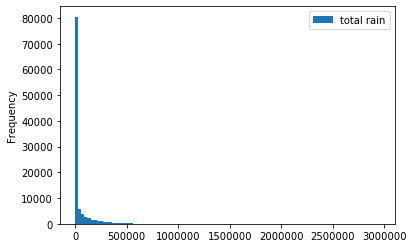

In [73]:
df.plot.hist(bins=100)

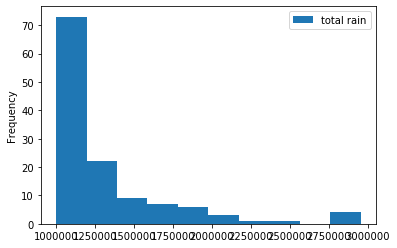

In [97]:
df[df['total rain']>1000000].plot.hist()

In the histogram above you can see that there are a lot of zeros in the data. Furthermore there appears to be an outlier at 3.000.000. So lets look at the outlier

In [36]:
df[df['total rain'] == df['total rain'].max()]

,total rain
date,
2019-06-06,2955275


In [81]:
2955275 * 0.01 * 0.01

295.52750000000003

In [63]:
df2 = df[df.index.month == 6]
df2 = df2[df2.index.day == 6]
df2.head(10)

,total rain
date,
2019-06-06 00:00:00,2955275
2019-06-06 00:05:00,1523977
2019-06-06 00:10:00,1649908
2019-06-06 00:15:00,1663556
2019-06-06 00:20:00,1797998
2019-06-06 00:25:00,1976869
2019-06-06 00:30:00,1991128
2019-06-06 00:35:00,1900455
2019-06-06 00:40:00,1771922


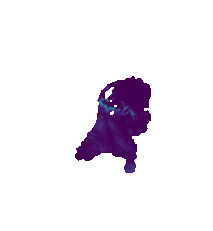

In [12]:
fn = '201906060000.nc'
rdr = load_radar(fn)
plot_radar(rdr)

In [25]:
path = '/nobackup_1/users/schreurs/project_GAN/dataset_radar_np/' + '201906060000.npy'
rdr = np.load(path)
np.unique(rdr)

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

In [72]:
dir_rtcor = '/nobackup_1/users/schreurs/project_GAN/dataset_radar/'
rtcor_fbase = 'RAD_NL25_RAC_RT_'


fn = '201905281900.h5'
path= dir_rtcor+rtcor_fbase+fn
with h5py.File(path, 'r') as f:
    rain = f['image1']['image_data'][:]
    mask= (rdr == 65535)
    mx = np.ma.masked_array(rain, mask)
print(np.sum(mx==255))
np.unique(mx)

104340


masked_array(data=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                   16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                   30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
                   44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
                   58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
                   72, 73, 74, 76, 77, 78, 83, 84, 85, 86, 88, 94, 95, 96,
                   97, 104, 105, 106, 109, 115, 127, 148, 177, 178, 255],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, Fa

In [28]:
fn = '201906060000.nc'
rdr = load_radar(fn, as_int=True)
np.unique(rdr)

masked_array(data=[0, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19,
                   21, 22, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36, 37,
                   38, 39, 41, 42, 44, 45, 47, 48, 50, 51, 52, 53, 55, 56,
                   57, 58, 59, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72,
                   74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 87, 88, 89,
                   90, 91, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103,
                   104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115,
                   116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127,
                   128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139,
                   140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151,
                   152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163,
                   164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175,
                   176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187,
                   188, 189, 190, 19

In [70]:
df[df.index == datetime(2019, 6, 5, 23, 55)]

,total rain
date,
2019-06-05 23:55:00,2923661


In [1]:
fn = '201906052355.nc'
rdr = load_radar(fn)
plot_radar(rdr)

NameError: name 'load_radar' is not defined

When googling the data, I found the following [article](https://www.knmi.nl/kennis-en-datacentrum/achtergrond/code-oranje-voor-onweersbuien-op-5-juni-2019#:~:text=Om%2000.07%20uur%20(6%20juni,naar%20noord%20over%20het%20land)). On this date there was a warning for heavy precipitation and thunder, so an outlier makes sense in this context.

“Zware onweersbuien met lokaal (zeer) zware windstoten, veel neerslag en kans op hagel - Een gebied met met zware onweersbuien trekt de komende uren van zuid naar noord over het land. Hierbij komen lokaal (zeer) zware windstoten van 75-100 km/uur voor, zeer lokaal mogelijk boven de 100 km/uur. Tevens valt er lokaal veel neerslag en kan er hagel voorkomen.”

Next I will look at the no rain data:

In [102]:
len(df[df > 1])/len(df)

1.0

## Cropping aart radar images

The actual radar image only take up a small part of the 765 by 700 area. By cropping the image the model needs to predict less pixels.

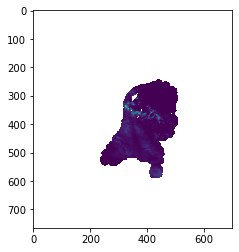

In [22]:
fn = '201906060000'
y_path = '/nobackup_1/users/schreurs/project_GAN/dataset_aart_np'
path = y_path + '/{}.npy'.format(fn)

rain = np.load(path)
# set masked values to 0
mask = (rain == 6553500)
rain[rain == 6553500] = 0
# Expand dimensions from (w,h) to (w,h,c=1)
rain = np.expand_dims(rain, axis=-1)


mx = np.ma.masked_array(rain, mask)
plt.imshow(np.squeeze(mx))

(384, 350)

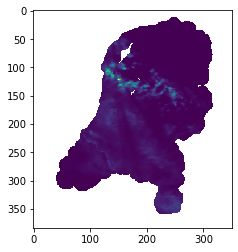

In [47]:
def crop_center(img,cropx=350,cropy=384):
    y,x = img.shape
    startx = 20+x//2-(cropx//2)
    starty = 40+y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

w = 350
h = 384
rain2 = crop_center(np.squeeze(rain), w, h)
mask2 = crop_center(mask, w, h)

mx2 = np.ma.masked_array(rain2, mask2)
plt.imshow(np.squeeze(mx2))
mx2.shape

In [ ]:
def uncrop_center(img,cropx=350,cropy=384):
    y,x = img.shape
    startx = 20+x//2-(cropx//2)
    starty = 40+y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

w = 350
h = 384
rain2 = crop_center(np.squeeze(rain), w, h)
mask2 = crop_center(mask, w, h)

mx2 = np.ma.masked_array(rain2, mask2)
plt.imshow(np.squeeze(mx2))
mx2.shape

## Mean and STD of the data

If we have the mean and std of the data then we can perform z-score normalization.  First an approximation of the dataset mean and std is made by taking a random sample of the dataset. We leave the calculation of the actual mean and std as future work, as this will take a bit longer.

In [236]:
radar_dir = '/nobackup_1/users/schreurs/project_GAN/dataset_aart'
files = sorted([f for f in listdir(radar_dir) if isfile(join(radar_dir, f)) and f.endswith('.nc')])

In [308]:
# Get random samples
n = 288*100
files_sample = np.random.choice(files, n)

print('Sampled size is {:.2f}% of the actual dataset'.format(100*len(files_sample)/len(files)))


Sampled size is 2.28% of the actual dataset


First calculate mean. Then the std can be calculated by using this mean

In [309]:
sample_sum=0
n_pixels=0
for file in tqdm(files_sample):
    rdr = load_radar(file, as_int=True)
    sample_sum+= int(rdr.filled(0).sum())
    
    # Nr of unmasked pixels:
    n_pixels+= 55739
sample_avg = sample_sum/n_pixels
print(sample_avg)

100%|██████████| 28800/28800 [09:29<00:00, 50.61it/s]

0.7740296547051635


In [311]:
sum_x_min_mean_square=0
n_pixels=0
for file in tqdm(files_sample):
    rdr = load_radar(file, as_int=True)
    
    try:
        int(rdr.sum())
        sum_x_min_mean_square +=  np.sum(np.square(rdr - sample_avg))
    except:
        sum_x_min_mean_square +=  np.sum(np.square(np.repeat(0,55739) - sample_avg))    
    n_pixels+= 55739
sample_std =  sum_x_min_mean_square/n_pixels
print(sample_std)

100%|██████████| 28800/28800 [05:12<00:00, 92.18it/s]

37.88184326601481


## Plotting data on map

In [4]:
dir_aart = '/nobackup_1/users/schreurs/project_GAN/dataset_aart/'
aart_fbase = 'RAD_NL25_RAC_MFBS_EM_5min_'

ts = '202001010000'
path = dir_aart + aart_fbase + ts + '.nc'

ds = netCDF4.Dataset(path, 'r')
ds
   

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.5
    history: Metadata adjusted by ADAGUC from KNMIHDF5 to NetCDF-CF
    dimensions(sizes): y(765), x(700), time(1)
    variables(dimensions): float64 y(y), float64 x(x), float64 time(time), |S1 geographic(), |S1 image1_calibration(), uint16 image1_image_data(time,y,x), |S1 overview(), |S1 radar1(), |S1 radar2(), |S1 radar3(), |S1 product(), |S1 iso_dataset(), |S1 projection()
    groups: 

In [6]:
x = ds['x'][:][0]
y = ds['y'][:][0]
print(x,y)
p = Proj("+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378.137 +b=6356.752 +x_0=0 +y_0=0")
lon, lat = p(x, y, inverse=True)
print(lat, lon)

0.5 -3650.5
55.969160591296045 0.007847661848348265


In [7]:
def plot_on_map(ts, ftype='.nc', res='l'):
    '''
    Plot radar file on top of map.
    ts: Input is timestamp in format yyyymmddhhmm (e.g. 202001010000)
    ftype: file type of the radar file, this can be .nc or .h5
    res: resolution, can be c (crude), l (low), i (intermediate), h (high), f (full) 
    '''
    
    dir_aart = '/nobackup_1/users/schreurs/project_GAN/dataset_aart/'
    aart_fbase = 'RAD_NL25_RAC_MFBS_EM_5min_'
    p_aart = Proj("+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378.137 +b=6356.752 +x_0=0 +y_0=0")
    
    if ftype == '.nc':
        path = dir_aart + aart_fbase + ts + ftype
        with netCDF4.Dataset(path, 'r') as ds:
            # Get coordinates of the pixels
            xx, yy = np.meshgrid(ds['x'][:], ds['y'][:])
            lon, lat = p_aart(xx, yy, inverse=True)
            
            rain = ds['image1_image_data'][:][0]
            
            # Plot values on map
            iso_dict = ds['iso_dataset'].__dict__
            min_x = float(iso_dict['min_x'].replace('f', ''))
            min_y = float(iso_dict['min_y'].replace('f', ''))
            max_x = float(iso_dict['max_x'].replace('f', ''))
            max_y = float(iso_dict['max_y'].replace('f', ''))
            
            mp = Basemap(projection='stere',
                         lat_0=90,
                         lon_0=0, 
                         lat_ts=60,   
                         llcrnrlon=min_x,   # lower longitude
                         llcrnrlat=min_y,    # lower latitude
                         urcrnrlon=max_x,   # uppper longitude
                         urcrnrlat=max_y,   # uppper latitude
                         resolution='l'
                        )
            mp.drawcoastlines()
            mp.drawstates()
            mp.drawcountries()

            xx, yy = mp(lon, lat)
            plt.contour(xx, yy, rain, latlon=True, cmap='coolwarm')
            plt.show()

In [242]:
def plot_on_map(ts, ftype='.nc', res='l'):
    '''
    Plot radar file on top of map.
    ts: Input is timestamp in format yyyymmddhhmm (e.g. 202001010000)
    ftype: file type of the radar file, this can be .nc or .h5
    res: resolution, can be c (crude), l (low), i (intermediate), h (high), f (full) 
    '''
    
    dir_aart = '/nobackup_1/users/schreurs/project_GAN/dataset_aart/'
    aart_fbase = 'RAD_NL25_RAC_MFBS_EM_5min_'
    
    proj = Proj("+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378.137 +b=6356.752 +x_0=0 +y_0=0")
    
    # All images are plotted on the same map
    # Get the map from random nc file
    path = dir_aart + aart_fbase + '201901010000.nc'
    with netCDF4.Dataset(path, 'r') as ds:
        # Get coordinates of the pixels
        xx, yy = np.meshgrid(ds['x'][:], ds['y'][:])
        lon, lat = proj(xx, yy, inverse=True)
        # Plot values on map
        iso_dict = ds['iso_dataset'].__dict__
        min_x = float(iso_dict['min_x'].replace('f', ''))
        min_y = float(iso_dict['min_y'].replace('f', ''))
        max_x = float(iso_dict['max_x'].replace('f', ''))
        max_y = float(iso_dict['max_y'].replace('f', ''))
        
    rain = np.squeeze(load_radar(ts+ftype, as_int=True))
    rain[rain == 65535 ] = 0
    
    # Plot the precipitation on map  
    mp = Basemap(projection='stere',
                         lat_0=90,
                         lon_0=0, 
                         lat_ts=60,   
                         llcrnrlon=min_x,   # lower longitude
                         llcrnrlat=min_y,    # lower latitude
                         urcrnrlon=max_x,   # uppper longitude
                         urcrnrlat=max_y,   # uppper latitude
                         resolution='l'
                        )
    mp.drawcoastlines()
    mp.drawstates()
    mp.drawcountries()

    xx, yy = mp(lon, lat)
    #cm = LinearSegmentedColormap.from_list('whitebluered', [[1,1,1],[0,0,1],[1,0,0]])
    cmap = cm.Blues

    cmap.set_under('white')
    plt.contourf(xx, yy, rain, cmap=cmap, vmin=30, vmax=1000)
    print(np.unique(rain)[:10])
    plt.colorbar(extend='both')
    plt.show()


<ipython-input-242-ea6d67b040c7>:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__


[0 1 2 3 4 5 6 7 8 9]


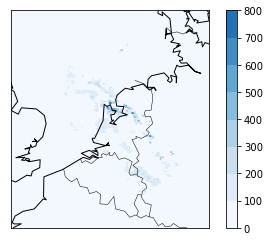

In [243]:
ts = '201906060000'
plot_on_map(ts, ftype='.h5')

# Look at samples labeled with containing rain

In [13]:
ls /nobackup_1/users/schreurs/project_GAN/

aart_rain_labels/    explore_downloaded_data.ipynb  raindata2019.zip
dataset_aart/        mean_rain2020.npy              rtcor_rain_labels/
dataset_aart_np/     mean_rain_aart2019.npy         sum_rain2020.npy
dataset_radar/       mean_rain.npy                  sum_rain_aart2019.npy
dataset_radar_np/    raindata2019/
download_dataset.py  raindata2019_tar


In [14]:
label_dir = '/nobackup_1/users/schreurs/project_GAN/aart_rain_labels/'
labels = sorted([f for f in listdir(label_dir) if isfile(join(label_dir, f)) and f.endswith('.npy')])
len(labels)

105119

In [30]:
aart_dir_npy = '/nobackup_1/users/schreurs/project_GAN/dataset_aart_np/'
rtcor_dir_npy = '/nobackup_1/users/schreurs/project_GAN/dataset_radar_np/'

In [20]:
rainy_days =[]
for label in labels[:10000]:
    norain = np.load(label_dir+label)
    if not norain:
        rainy_days.append(label)
len(rainy_days)

3378

In [24]:
from radarplot import plot_on_map

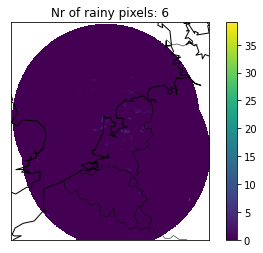

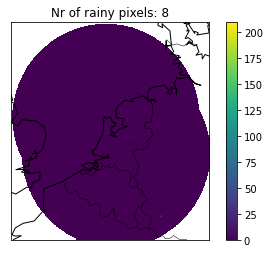

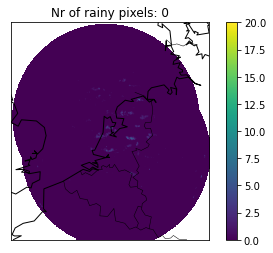

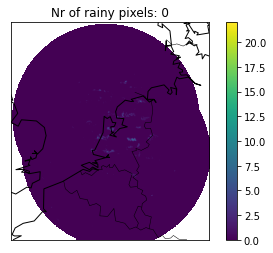

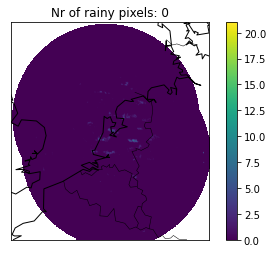

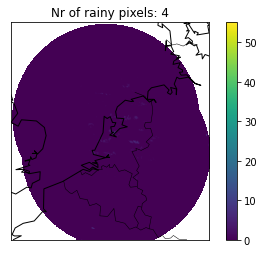

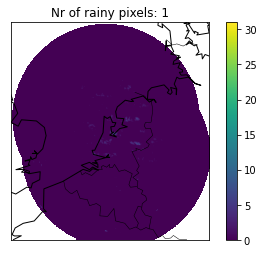

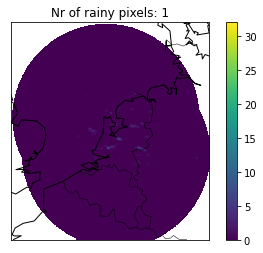

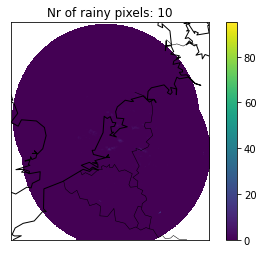

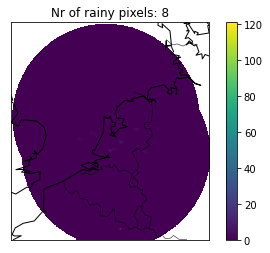

In [37]:
for day in rainy_days[:10]:
    rdr = np.load(rtcor_dir_npy + day)
    plot_on_map(rdr, ftype='.h5')
    plt.title('Nr of rainy pixels: {}'.format(np.sum(rdr>30)))
    plt.show()

# Data recor files (outdated)

In [168]:
# Open radar files in folder radarscans 2018-12-19 08:00 till 2018-12-20 07:55
radar_dir = './RAD25_OPER_R___TARRRT__L2__20181219080000_20181220075500_0001/'
onlyfiles = [f for f in listdir(radar_dir) if isfile(join(radar_dir, f))]

The image2 seems to be a binary mask with the lower value being 32768 and the upper value being 65535. Image1 has different value and seems to contain the actual precipitation data

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 27 38 41 42 43 48 62 63]


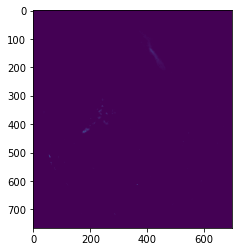

[32768 65535]


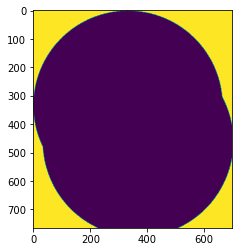

In [169]:
# Plot the image files:
h5f = h5py.File(radar_dir+onlyfiles[0], 'r')

radar_img = np.array(h5f['image1']['image_data'])
# change masked values to 0
radar_img[radar_img == 65535] = 0
plt.imshow(radar_img)
print(np.unique(radar_img.flatten()))
plt.show()

img_mask = np.array(h5f['image2']['image_data'])
print(np.unique(img_mask.flatten()))
plt.imshow(img_mask) # interpolation='none'
plt.show()

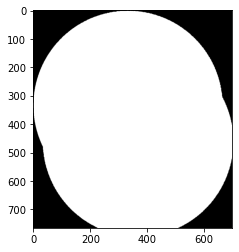

In [170]:
# Create function to obtain binary mask
def get_mask(h5f):
    mask = np.array(h5f['image2']['image_data'])
    mask[mask==32768] = 1
    mask[mask==65535] = 0
    return mask
mask = get_mask(h5f)
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
plt.show()

Find the minimum and maximum pixel value

In [171]:
# find max and min value of the radar scans
max_value=0
min_value=0
for i in range(len(onlyfiles)):
    h5f = h5py.File(radar_dir+onlyfiles[0], 'r')
    radar_img = np.array(h5f['image1']['image_data'])
    # change masked values to 0
    radar_img[radar_img == 65535] = 0
    if max(radar_img.flatten()) > max_value:
        max_value = max(radar_img.flatten())
    if min(radar_img.flatten()) < min_value:
        min_value = min(radar_img.flatten())
print('min = {}, max = {}'.format(min_value, max_value))

min = 0, max = 63


In [180]:
def plot_radar(h5file, show_mask=False, fileName=None):
    radar_img = np.array(h5file['image1']['image_data'])
    mask = get_mask(h5file)
    # apply mask to image
    img = radar_img*mask
    plt.imshow(img, vmin=min_value, vmax=max_value)
    plt.axis('off')
    if show_mask:
        plt.imshow(mask, cmap='binary', interpolation='none', alpha=0.2)
    if fileName:
        plt.savefig(fileName, bbox_inches='tight')
        display.clear_output(wait=True)
    plt.show()

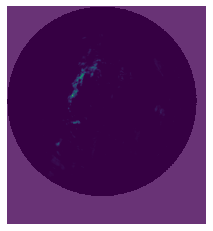

In [183]:
h5f = h5py.File(radar_dir+onlyfiles[-1], 'r')
plot_radar(h5f,show_mask=True, fileName='images/imague{}.png'.format(0))

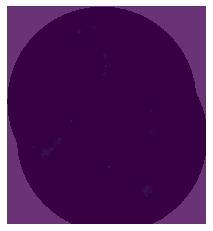

In [184]:
# save radar scans as images
for i in range(len(onlyfiles))[:100]:
    h5f = h5py.File(radar_dir+onlyfiles[i], 'r')
    plot_radar(h5f,show_mask=True, fileName='images/image{}.png'.format(i))

In [185]:
anim_file = 'precipitation.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

A gif of the precipitation is given below


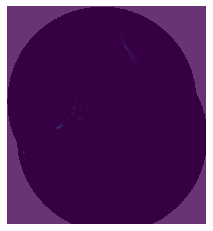

In [186]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)